In [1]:
from diffusers import DDPMScheduler
from defaults import pose_transfer_C as cfg
from pose_transfer_train import build_model
from models import UNet, VariationalAutoencoder
import torch
import os
import numpy as np
import pandas as pd
from pose_utils import (cords_to_map, draw_pose_from_cords,
                        load_pose_cords_from_strings)
import random
from PIL import Image
from torchvision import transforms
import copy

def build_pose_img(annotation_file, img_path):
    string = annotation_file.loc[os.path.basename(img_path)]
    array = load_pose_cords_from_strings(string['keypoints_y'], string['keypoints_x'])
    pose_map = torch.tensor(cords_to_map(array, (256, 256), (256, 176)).transpose(2, 0, 1), dtype=torch.float32)
    pose_img = torch.tensor(draw_pose_from_cords(array, (256, 256), (256, 176)).transpose(2, 0, 1) / 255., dtype=torch.float32)
    pose_img = torch.cat([pose_img, pose_map], dim=0)
    return pose_img

In [2]:
noise_scheduler = DDPMScheduler.from_pretrained("pretrained_models/scheduler/scheduler_config.json")
vae = VariationalAutoencoder(pretrained_path="pretrained_models/vae").eval().requires_grad_(False).cuda()
model = build_model(cfg).eval().requires_grad_(False).cuda()
unet = UNet(cfg).eval().requires_grad_(False).cuda()

In [3]:
import torch

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 将模型加载到 GPU
model = model.to(device)
unet = unet.to(device)


Using device: cuda


In [4]:
print(model.load_state_dict(torch.load(
    os.path.join("checkpoints", "pytorch_model.bin"), map_location=device
), strict=False))
print(unet.load_state_dict(torch.load(
    os.path.join("checkpoints", "pytorch_model_1.bin"), map_location=device
), strict=False))

<All keys matched successfully>
<All keys matched successfully>


In [5]:
test_pairs = os.path.join("fashion", "fasion-resize-pairs-test.csv")
test_pairs = pd.read_csv(test_pairs)
annotation_file = pd.read_csv(os.path.join("fashion", "fasion-resize-annotation-test.csv"), sep=':')
annotation_file = annotation_file.set_index('name')

fashionWOMENTees_Tanksid0000004801_7additional.jpg fashionWOMENTees_Tanksid0000004801_3back.jpg


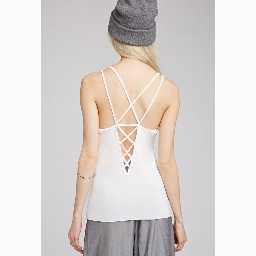

In [6]:
random_index = random.choice(range(len(test_pairs)))
img_from_path, img_to_path = test_pairs.iloc[random_index]["from"], test_pairs.iloc[random_index]["to"]
print(img_from_path,img_to_path)
img_from = Image.open(os.path.join("fashion", "test_highres", "test1.jpg")).convert("RGB")
img_to = Image.open(os.path.join("fashion", "test_highres", img_to_path)).convert("RGB")
img_from.resize((256, 256))
img_to.resize((256, 256))

In [7]:
trans = transforms.Compose([
    transforms.Resize([256, 256], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
img_from_tensor = trans(img_from).unsqueeze(0)
print(img_from_tensor.shape)

torch.Size([1, 3, 256, 256])


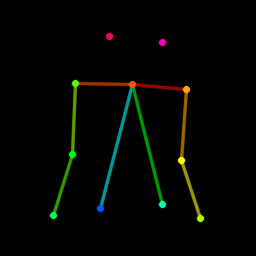

In [8]:
pose_img_tensor = build_pose_img(annotation_file, img_to_path).unsqueeze(0)
Image.fromarray((pose_img_tensor[0][:3].permute((1, 2, 0)) * 255.).long().numpy().astype(np.uint8))

In [9]:
with torch.no_grad():
    c_new, down_block_additional_residuals, up_block_additional_residuals = model({
        "img_cond": img_from_tensor.cuda(), "pose_img": pose_img_tensor.cuda()})
    noisy_latents = torch.randn((1, 4, 64, 64)).cuda()
    weight_dtype = torch.float32
    bsz = 1

    c_new = torch.cat([c_new[:bsz], c_new[:bsz], c_new[bsz:]])
    down_block_additional_residuals = [torch.cat([torch.zeros_like(sample), sample, sample]).to(dtype=weight_dtype) \
                                        for sample in down_block_additional_residuals]
    up_block_additional_residuals = {k: torch.cat([torch.zeros_like(v), torch.zeros_like(v), v]).to(dtype=weight_dtype) \
                                        for k, v in up_block_additional_residuals.items()}

    noise_scheduler.set_timesteps(cfg.TEST.NUM_INFERENCE_STEPS)
    for t in noise_scheduler.timesteps:
        inputs = torch.cat([noisy_latents, noisy_latents, noisy_latents], dim=0)
        inputs = noise_scheduler.scale_model_input(inputs, timestep=t)
        noise_pred = unet(sample=inputs, timestep=t, encoder_hidden_states=c_new,
            down_block_additional_residuals=copy.deepcopy(down_block_additional_residuals),
            up_block_additional_residuals=copy.deepcopy(up_block_additional_residuals))

        noise_pred_uc, noise_pred_down, noise_pred_full = noise_pred.chunk(3)
        noise_pred = noise_pred_uc + \
                        cfg.TEST.DOWN_BLOCK_GUIDANCE_SCALE * (noise_pred_down - noise_pred_uc) + \
                        cfg.TEST.FULL_GUIDANCE_SCALE * (noise_pred_full - noise_pred_down)
        noisy_latents = noise_scheduler.step(noise_pred, t, noisy_latents)[0]

    sampling_imgs = vae.decode(noisy_latents) * 0.5 + 0.5 # denormalize
    sampling_imgs = sampling_imgs.clamp(0, 1)

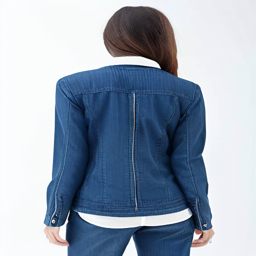

In [10]:
Image.fromarray((sampling_imgs[0] * 255.).permute((1, 2, 0)).long().cpu().numpy().astype(np.uint8)).resize((256, 256))